In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from surprise import Reader, Dataset
from surprise import SVD, accuracy

### Method 1 (Modifying Code from Homework 5)

In [2]:
np.random.seed(42)

# Create m x n matrix for Y
Y_train = np.loadtxt('./data/train_cleaned.txt').astype(int)
Y_test = np.loadtxt('./data/test_cleaned.txt').astype(int)

In [3]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes an input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes an input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))

def get_err(U, V, Y, reg=0.0):
    """
    Takes an input of a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    err = 0
    for x in range(Y.shape[0]):
        i = Y[x][0] - 1
        j = Y[x][1] - 1
        
        err += pow(Y[x][2] - np.dot(U[i,:], V[j,:]), 2)    
    return 1 / Y.shape[0] * ((reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2) + err) / 2) 

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))
    loss = []
    loss.append(get_err(U, V, Y, reg))
    
    for epoch in range(max_epochs): 
        index = np.random.permutation(Y.shape[0])
        for idx in index:
            i = Y[idx][0] - 1
            j = Y[idx][1] - 1
            U[i,:] -= grad_U(U[i,:], Y[idx][2], V[j,:], reg, eta)
            V[j,:] -= grad_V(V[j,:], Y[idx][2], U[i,:], reg, eta)
        
        err = get_err(U, V, Y, reg)
        loss.append(err)
        if (abs(loss[-1] - loss[-2]) / abs(loss[1] - loss[0]) < eps):
            break
    
    err = get_err(U, V, Y)
    return (U, V, err)

In [4]:
# Create 943 users x 1682 movies 
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

k = 20
reg = 0.0
eta = 0.03 # learning rate

U, V, E_in = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Factorizing with  943  users,  1682  movies.
Training error is: 0.25376216473519914
Test error is: 0.6529683806078138


In [18]:
# Visualize and interpret results
def visualize(U, V):
    ''' 
        U (k x M)
        V (k x N)
    '''
    A, sigma, B = np.linalg.svd(V)
    U_tilde = np.matmul(np.transpose(A[:,:2]), U)
    V_tilde = np.matmul(np.transpose(A[:,:2]), V)
    return U_tilde, V_tilde
    
U_tilde, V_tilde = visualize(np.transpose(U), np.transpose(V))

In [6]:
colnames = ['movie_id', 'title', 'unknown', "action", "adventure", "animation", 
            "childrens", "comedy", "crime", "documentary", "drama", "fantasy", 
            "film-noir", "horror", "musical", "mystery", "romance", "sci-fi", 
            "thriller", "war", "western"]
movie_info = pd.read_csv("data/movies.txt", names=colnames, sep='\t', header=None)

movie_to_genre = dict()

for index, row in movie_info.iterrows():
    if row['title'] not in movie_to_genre:
        movie_to_genre[row['title']] = row['unknown':'western'].to_numpy()

id_to_movie_title = movie_info['title'].tolist()
id_to_movie_title.insert(0, "NO MOVIE WITH ID 0")

movie_to_id = dict()

for i in range(1,len(id_to_movie_title)):
    if (id_to_movie_title[i] not in movie_to_id):
        movie_to_id[id_to_movie_title[i]] = i        

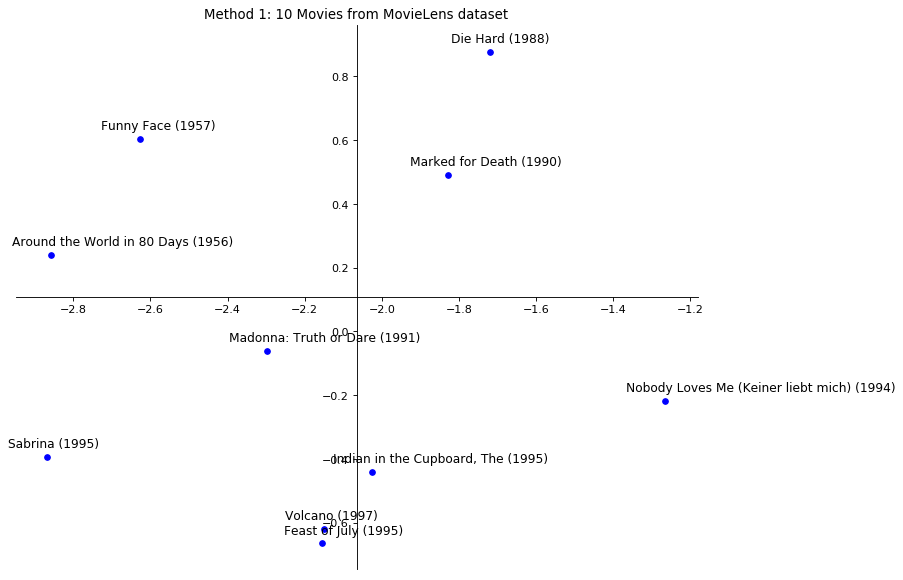

In [7]:
movies = np.random.choice(list(movie_to_genre.keys()), 10)
movie_ids = [movie_to_id[m] for m in movies]

# ====================== TEN CHOSEN MOVIES PLOT ======================
V_ten = np.take(np.transpose(V_tilde), movie_ids, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_ten)):
    x = V_ten[i][0]
    y = V_ten[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, movies[i], fontsize=11)
plt.title('Method 1: 10 Movies from MovieLens dataset')
plt.show()

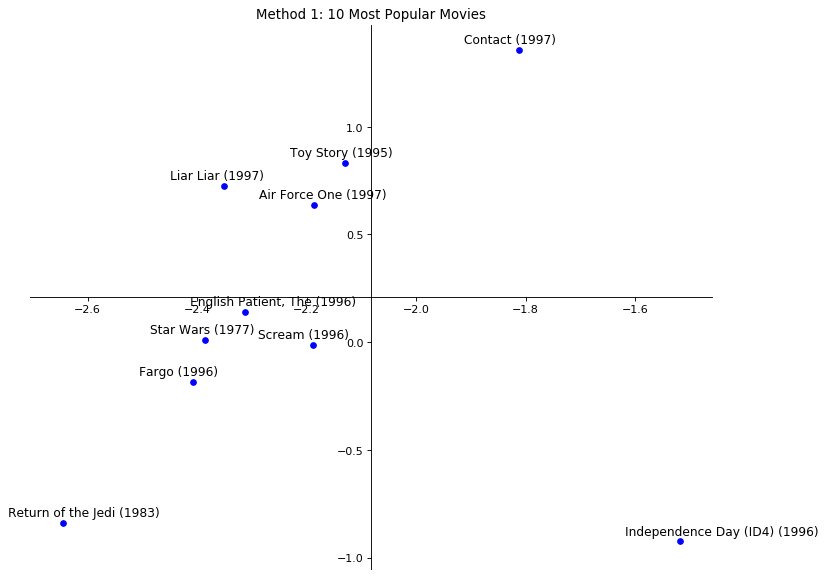

In [9]:
popular_movies = ['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 
                  'Return of the Jedi (1983)', 'Liar Liar (1997)', 
                  'English Patient, The (1996)', 'Scream (1996)', 
                  'Toy Story (1995)', 'Air Force One (1997)', 
                  'Independence Day (ID4) (1996)']
pop_movies_id = [movie_to_id[m] for m in popular_movies]

# ====================== TEN MOST POPULAR MOVIES PLOT ======================
V_pop = np.take(np.transpose(V_tilde), pop_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_pop)):
    x = V_pop[i][0]
    y = V_pop[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, popular_movies[i], fontsize=11)
plt.title('Method 1: 10 Most Popular Movies')
plt.show()

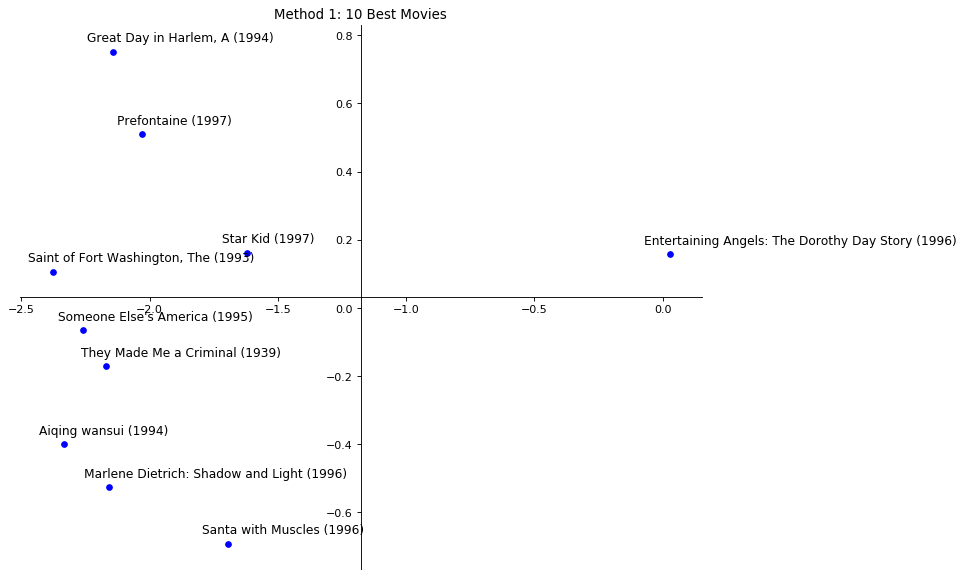

In [12]:
best_movies = ['Prefontaine (1997)', 'Santa with Muscles (1996)', 
               'Great Day in Harlem, A (1994)', 'Aiqing wansui (1994)', 
               'Star Kid (1997)', "Someone Else's America (1995)", 
               'Entertaining Angels: The Dorothy Day Story (1996)', 
               'Saint of Fort Washington, The (1993)', 
               'They Made Me a Criminal (1939)', 
               'Marlene Dietrich: Shadow and Light (1996) ']

best_movies_id = [movie_to_id[m] for m in best_movies]

# ====================== TEN BEST MOVIES PLOT ======================
V_best = np.take(np.transpose(V_tilde), best_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_best)):
    x = V_best[i][0]
    y = V_best[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, best_movies[i], fontsize=11)
plt.title('Method 1: 10 Best Movies')
plt.show()

In [14]:
action = []
drama = []
fantasy = []

for key, val in movie_to_genre.items():
    if val[1]:
        action.append(key)
    if val[8]:
        drama.append(key)
    if val[9]:
        fantasy.append(key)
        
action = np.random.choice(action, 10)
action_id = [movie_to_id[m] for m in action]

drama = np.random.choice(drama, 10)
drama_id = [movie_to_id[m] for m in drama]

fantasy = np.random.choice(fantasy, 10)
fantasy_id = [movie_to_id[m] for m in fantasy]

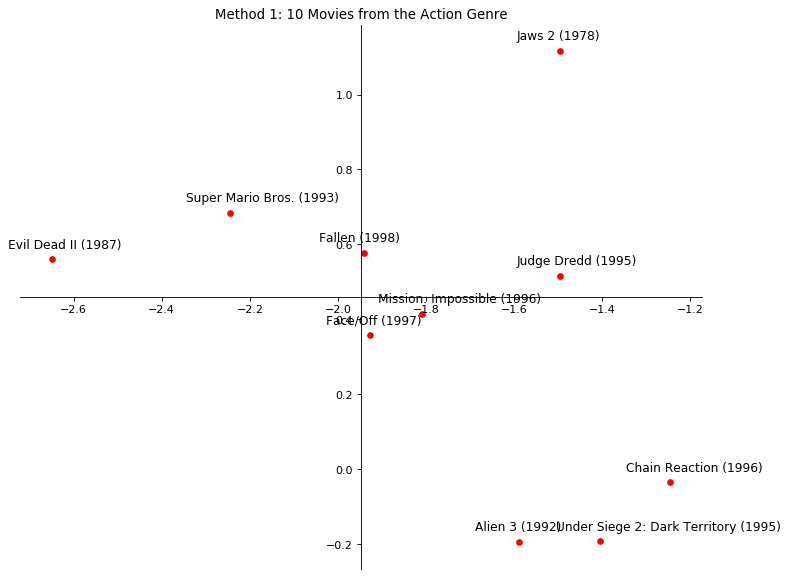

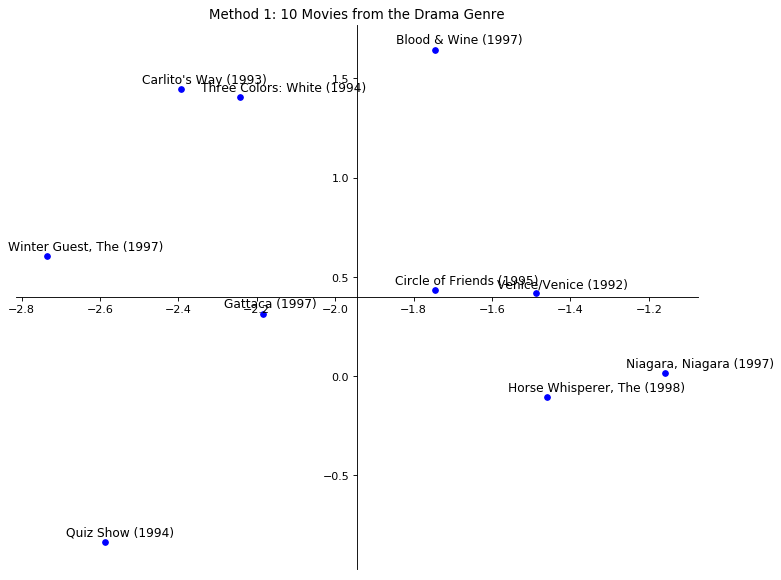

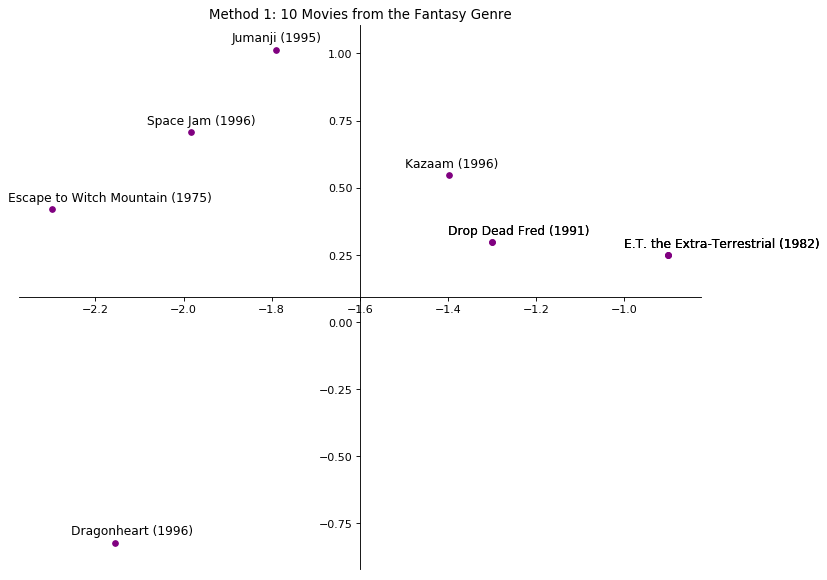

In [16]:
# ====================== TEN MOVIES FROM EACH OF THE THREE GENRES PLOT ======================

# ACTION GENRE
V_action = np.take(np.transpose(V_tilde), action_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_action)):
    x = V_action[i][0]
    y = V_action[i][1]
    plt.scatter(x, y, marker='.', color='red', s=100)
    plt.text(x - 0.1, y + 0.03, action[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Action Genre')
plt.show()

# DRAMA GENRE
V_drama = np.take(np.transpose(V_tilde), drama_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_drama)):
    x = V_drama[i][0]
    y = V_drama[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, drama[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Drama Genre')
plt.show()

# FANTASY GENRE
V_fantasy = np.take(np.transpose(V_tilde), fantasy_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_fantasy)):
    x = V_fantasy[i][0]
    y = V_fantasy[i][1]
    plt.scatter(x, y, marker='.', color='purple', s=100)
    plt.text(x - 0.1, y + 0.03, fantasy[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Fantasy Genre')
plt.show()